In [1]:
pwd()

"/home/xlx0727/Scripts/Statistic/qgplsim"

# Start

In [4]:
# run this ceil if source codes was edited
include("DGP.ji")
include("qgplsim.ji")
using Statistics, LinearAlgebra
using LaTeXStrings

import Base.Threads.@threads

# QGPLSIM fitting

In [5]:
# run this ceil for different data sets

α = [1.0, -0.5] # single index for x
θ = [1.0, 2.0] # linear for x, <α, θ> = 0 for identification
γ = [1.0, 0.5] # single index for z
β = [0.5, -1.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 400
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha, theta, gamma, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

theta * alpha

  9.102298 seconds (14.40 M allocations: 22.745 GiB, 14.01% gc time, 44.26% compilation time)
Estimation of index coefs: 
̂α => [0.9637139336616946, -0.26693717250750776]
̂γ => [0.013726363738347255, 0.024245525171430502]
Estimation of linear coefs: 
̂θ => [0.5678343441384666 2.0500324638843574]
̂β => [0.6997470366579142, -0.6718543032776734]


1-element Vector{Float64}:
 1.1102230246251565e-16

In [304]:
norm(alpha)

1.0

# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

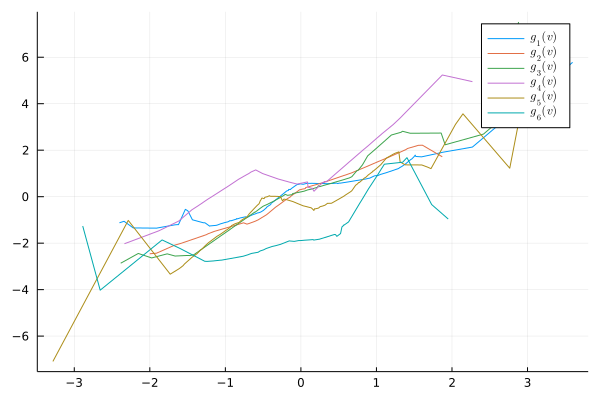

In [10]:
using Plots

v = X * alpha # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y) # g: g(v), dg: g'(v)
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]

    plot!(fig, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")

end
fig

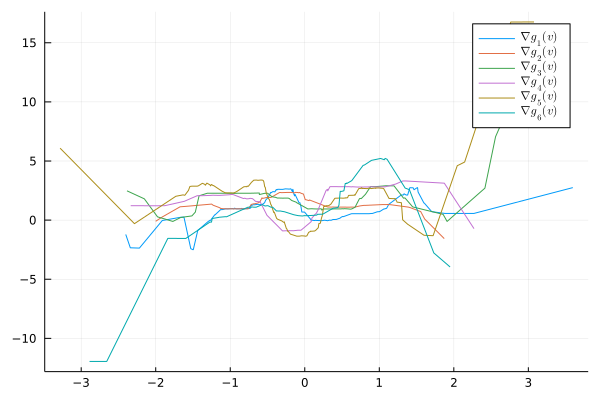

In [11]:
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_vm = vm[indm]
    plot!(fig, sorted_vm, sorted_dgm, label = L"\nabla g_{%$m} (v)")

end
fig

# Monte Carlo Simulation

In [294]:
include("MonteCarloSIM.ji")

simulation (generic function with 1 method)

In [297]:
using DataFrames
df = DataFrame(α1 = Float64[], α2 = Float64[],
               var_α1 = Float64[], var_α2 = Float64[],    
               θ1 = Float64[], θ2 = Float64[],
               var_θ1 = Float64[], var_θ2 = Float64[], 
               β1 = Float64[], β2 = Float64[],
               var_β1 = Float64[], var_β2 = Float64[], 
               γ1 = Float64[], γ2 = Float64[],
               var_γ1 = Float64[], var_γ2 = Float64[])


,α1,α2,var_α1,var_α2,θ1,θ2,var_θ1,var_θ2,β1
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [296]:
A = [:α1, :α2, :var_α1, :var_α2]
T = [:θ1, :θ2, :var_θ1, :var_θ2]
G = [:γ1, :γ2, :var_γ1, :var_γ2]
B = [:β1, :β2, :var_β1, :var_β2]

4-element Vector{Symbol}:
 :β1
 :β2
 :var_β1
 :var_β2

MC Computing time: 440.62543988227844
MC Computing time: 462.6044681072235
MC Computing time: 1242.486044883728


In [288]:
Threads.nthreads()

4

## y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ

In [298]:
α = [1.0, 0.5] # single index for x
θ = [1.0, -2.0]  # linear for x, <α, θ> = 0 for identification
# γ = [1.0, 0.5] # single index for z
β = [1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 100
alpha_type = 1

@threads for γ in [[1.0, 0.5], [1.0, 0.0], [0.0, 1.0], [0.5, 1.0], [0.0001, 0.0001]]
    res =  MonteCarlo(n, γ, θ, α, β, alpha_type)
    push!(df, res)
end
df[!, vcat(A, G)]

MC Computing time: 456.5116090774536
MC Computing time: 59.86122393608093
MC Computing time: 52.17522192001343
MC Computing time: 467.83101296424866
MC Computing time: 464.3312451839447
MC Computing time: 50.158576011657715
MC Computing time: 1277.6355948448181
MC Computing time: 2619.6483211517334
MC Computing time: 1007.6531760692596
MC Computing time: 957.7528150081635
MC Computing time: 2025.3656589984894
MC Computing time: 956.6462211608887
MC Computing time: 35.325392961502075
MC Computing time: 1715.0944299697876
MC Computing time: 1495.9095108509064
MC Computing time: 1517.6130390167236
MC Computing time: 34.435142040252686


,α1,α2,var_α1,var_α2,γ1,γ2,var_γ1,var_γ2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.737259,0.389072,0.0637255,0.244428,1.77733,0.890324,0.376759,0.113782
2,0.79319,0.292294,0.0642209,0.224076,2.17492,0.0755358,0.842764,0.211557
3,0.802862,0.250892,0.043519,0.2519,0.123922,1.58767,0.203591,0.337679
4,0.770681,0.225459,0.0652585,0.293548,0.70375,1.4779,0.248469,0.27151
5,0.774351,0.261981,0.0545546,0.280542,0.453601,0.0580974,0.277826,0.196617


In [289]:
using CSV


In [290]:
CSV.write("gamma.csv", df)

"gamma.csv"